## 一句话概括公园系统数据分析和可视化:将数据分组聚合并映射在格子上,然后做图

### 绘制网格

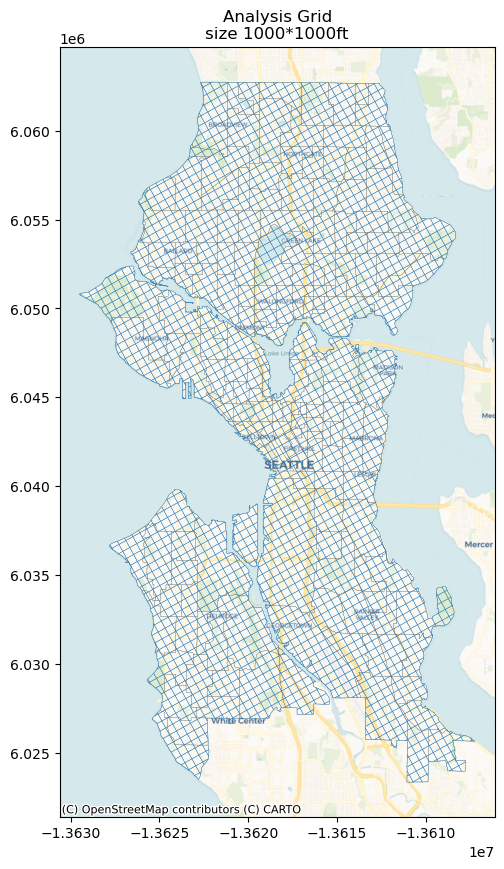

In [1]:
# Required Libraries
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from contextily import add_basemap
import contextily as cx

# 加载seattle boundary
seattle_boundary = gpd.read_file("Seattle_City_Boundary.geojson")
seattle_boundary = seattle_boundary.to_crs(epsg=2272)  # Transform to a projection in feet

# 设置grid大小
grid_size = 1000  # 1000 feet

# 在seattle boundary 绘制 grids
minx, miny, maxx, maxy = seattle_boundary.total_bounds
x_range = maxx - minx
y_range = maxy - miny

# 绘制grids
rows = int(y_range / grid_size)
cols = int(x_range / grid_size)
grid = []
for i in range(cols + 1):
    for j in range(rows + 1):
        grid.append(box(minx + i * grid_size, miny + j * grid_size, minx + (i + 1) * grid_size, miny + (j + 1) * grid_size))


# 选择适合的投影坐标系统
projected_crs = '3857'  # Web Mercator 投影
# 确保 CRS 转换

grid_gdf = gpd.GeoDataFrame(geometry=grid, crs=seattle_boundary.crs)
grid_gdf = gpd.clip(grid_gdf, seattle_boundary)
grid_gdf = grid_gdf.to_crs(epsg=projected_crs)
seattle_boundary = seattle_boundary.to_crs(epsg=projected_crs)

# 计算几何中心
centroids = grid_gdf.centroid

# Plot the grid
fig, ax = plt.subplots(figsize=(10, 10))

seattle_boundary.plot(ax=ax, color='none', edgecolor='black',linewidth=0.1)
grid_gdf.plot(ax=ax, facecolor='none', edgecolor='#3182bd', linewidth=0.3)
# Add basemap
cx.add_basemap(ax, crs=grid_gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom=12)

plt.title("Analysis Grid\nsize 1000*1000ft")
plt.show()

### 公园等时线分析

#### 分地块的公园数量统计:每块格栅有几个公园

In [2]:
parks = gpd.read_file('SeattleParkPoints.geojson')
parks_proj = parks.to_crs(epsg = 3857) # 计算几何中心 | 裁剪 | 面积计算 | 距离测量 | EPSG:3857 
parks_proj.head(3)

OBJECTID             PROPNAME             ADDRESS DIVISION  ADA  \
0      7044      Alki Playground   5817 SW Lander St    South  Yes   
1      7045  B.F. Day Playground  4020 Fremont Ave N    North  Yes   
2      7046   Ballard Playground     2644 NW 60th St    North  Yes   

                      GIS_EDT_DT   LATITUDE   LONGITUDE       POINT_X  \
0  Mon, 29 Jul 2024 19:16:43 GMT  47.577899 -122.407731  1.251850e+06   
1  Mon, 29 Jul 2024 19:16:43 GMT  47.655668 -122.348906  1.266925e+06   
2  Mon, 29 Jul 2024 19:16:43 GMT  47.672648 -122.392548  1.256297e+06   

         POINT_Y  ... LOCID      AMWO_ID  RES1  RES2  \
0  214775.000001  ...  1049  PLAY-ALKIPG  None  None   
1  242845.296892  ...  2552   PLAY-DAYPG  None  None   
2  249252.812470  ...  1108    PLAY-BLPG  None  None   

                               GLOBALID                  GIS_CREATOR  \
0  17ca3d9c-c23f-41f4-927f-5f4583822a15  SeattleParks_SeattleCityGIS   
1  2b87dea1-038d-4a59-98f0-db9ad09725ff  SeattleParks_SeattleCityGIS   
2  ff837c9b-46fd-4b79-8eda-d51a40268425  SeattleParks_SeattleCityGIS   

                      GIS_CRT_DT                   GIS_EDITOR   SDQL  \
0  Mon, 29 Jul 2024 19:16:43 GMT  SeattleParks_SeattleCityGIS  QL-D3   
1  Mon, 29 Jul 2024 19:16:43 GMT  SeattleParks_SeattleCityGIS  QL-D3   
2  Mon, 29 Jul 2024 19:16:43 GMT  SeattleParks_SeattleCityGIS  QL-D3   

                            geometry  
0  POINT (-13626367.925 6036918.326)  
1  POINT (-13619819.517 6049761.138)  
2  POINT (-13624677.828 6052567.874)  

[3 rows x 21 columns]

In [3]:
from pyproj import Transformer 
# 这行代码从 pyproj 库中导入 Transformer 类。Transformer 类用于进行坐标变换，能够将一个坐标参考系统（CRS）中的坐标转换为另一个 CRS 中的坐标
import geopandas as gpd
from shapely.geometry import Point 
# 这行代码从 shapely 库的 geometry 模块中导入 Point 类。Point 类用于表示二维空间中的一个点，通常用于地理空间数据中的坐标点

# 定义坐标转换的函数
def transform_point(_transformer,point):
# _transformer 是一个 Transformer 对象，用于进行坐标转换；point 是一个 Point 对象，表示需要转换的点
    lon,lat = _transformer.transform(point.x,point.y)
    # 这行代码调用 _transformer 对象的 transform 方法，将 point 的 x 和 y 坐标进行转换。转换后的结果分别赋值给变量 lon 和 lat
    return Point(lon,lat)

In [4]:
# 将公园数据分配给格栅单元格,空间连接
park_joined_gdf = gpd.sjoin(parks_proj,grid_gdf,how = 'left',predicate = 'intersects')
park_joined_gdf.head(3)

OBJECTID             PROPNAME             ADDRESS DIVISION  ADA  \
0      7044      Alki Playground   5817 SW Lander St    South  Yes   
1      7045  B.F. Day Playground  4020 Fremont Ave N    North  Yes   
2      7046   Ballard Playground     2644 NW 60th St    North  Yes   

                      GIS_EDT_DT   LATITUDE   LONGITUDE       POINT_X  \
0  Mon, 29 Jul 2024 19:16:43 GMT  47.577899 -122.407731  1.251850e+06   
1  Mon, 29 Jul 2024 19:16:43 GMT  47.655668 -122.348906  1.266925e+06   
2  Mon, 29 Jul 2024 19:16:43 GMT  47.672648 -122.392548  1.256297e+06   

         POINT_Y  ...      AMWO_ID  RES1  RES2  \
0  214775.000001  ...  PLAY-ALKIPG  None  None   
1  242845.296892  ...   PLAY-DAYPG  None  None   
2  249252.812470  ...    PLAY-BLPG  None  None   

                               GLOBALID                  GIS_CREATOR  \
0  17ca3d9c-c23f-41f4-927f-5f4583822a15  SeattleParks_SeattleCityGIS   
1  2b87dea1-038d-4a59-98f0-db9ad09725ff  SeattleParks_SeattleCityGIS   
2  ff837c9b-46fd-4b79-8eda-d51a40268425  SeattleParks_SeattleCityGIS   

                      GIS_CRT_DT                   GIS_EDITOR   SDQL  \
0  Mon, 29 Jul 2024 19:16:43 GMT  SeattleParks_SeattleCityGIS  QL-D3   
1  Mon, 29 Jul 2024 19:16:43 GMT  SeattleParks_SeattleCityGIS  QL-D3   
2  Mon, 29 Jul 2024 19:16:43 GMT  SeattleParks_SeattleCityGIS  QL-D3   

                            geometry index_right  
0  POINT (-13626367.925 6036918.326)         873  
1  POINT (-13619819.517 6049761.138)        3283  
2  POINT (-13624677.828 6052567.874)        2742  

[3 rows x 22 columns]

In [5]:
# 计算每个格栅的单元格数量,分类聚合
# 在使用 geopandas 进行空间连接（sjoin）时，index_right 是 geopandas.sjoin 函数默认生成的列之一，用于表示与连接结果中的目标 GeoDataFrame 的索引相关联的行。
park_counts = park_joined_gdf.groupby('index_right').size()
park_counts

index_right
211     2
397     1
400     1
666     1
760     1
       ..
5495    1
5505    1
5580    1
5690    1
5693    1
Length: 152, dtype: int64

In [6]:
grid_gdf.head()

geometry
2852  POLYGON ((-13608159.542 6024257.989, -13607787...
2853  POLYGON ((-13607787.488 6024509.448, -13607787...
2945  POLYGON ((-13607809.247 6024549.043, -13607787...
2854  POLYGON ((-13608375.281 6024650.517, -13608591...
3038  POLYGON ((-13607416.937 6025692.292, -13607389...

In [7]:
# 将park_counts连接回原始grid_gdf,并且将没有公园的格栅赋值为0,空间映射
grid_gdf['park_counts'] = grid_gdf.index.map(park_counts).fillna(0).astype(int)
# grid_gdf.index.map(park_counts) 是将 grid_gdf 的索引映射到 park_counts 上，即根据 grid_gdf 的索引值从 park_counts 中查找对应的数量。
# 如果 grid_gdf 的索引值在 park_counts 中存在，则返回对应的数量；如果不存在，则返回 NaN

grid_gdf.head(3)

geometry  park_counts
2852  POLYGON ((-13608159.542 6024257.989, -13607787...            0
2853  POLYGON ((-13607787.488 6024509.448, -13607787...            0
2945  POLYGON ((-13607809.247 6024549.043, -13607787...            0

#### 将公园经纬转化为中心点

In [8]:
import pandas as pd

In [9]:
# 创建一个函数将经纬度转换成shapely point对象
def create_point(row):
    if pd.notna(row['LONGITUDE']) and pd.notna(row['LATITUDE']):
        return Point(row['LONGITUDE'],row['LATITUDE'])

# 使用函数
park_centroids = parks_proj.apply(create_point,axis = 1) # 对 row 操作,axis = 1
# 去除无效数据
park_centroids = park_centroids[~(park_centroids == None)]
park_centroids

0       POINT (-122.40773 47.5779)
1      POINT (-122.34891 47.65567)
2      POINT (-122.39255 47.67265)
3       POINT (-122.38691 47.6443)
4       POINT (-122.36024 47.6289)
                  ...             
146    POINT (-122.39673 47.54037)
147    POINT (-122.32147 47.54499)
148    POINT (-122.29398 47.62767)
149    POINT (-122.35409 47.63589)
150    POINT (-122.40374 47.69178)
Length: 145, dtype: geometry

#### mapbox获取等时线

In [10]:
from shapely.geometry import Point, Polygon
from shapely.ops import transform
from pyproj import Transformer
import numpy as np
import time
import requests

# mapbox计算等时线
def get_isochrone_mapbox(centroid,profile = 'walking',minutes = 5,access_token = ''):
    lon,lat = centroid.x, centroid.y
    headers = {  
    'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/140.0.0.0 Safari/537.36'  
} 
    url = f'https://api.mapbox.com/isochrone/v1/mapbox/{profile}/{lon},{lat}?contours_minutes={minutes}&access_token={access_token}'
    retries = 3
    while retries > 0:
        response = requests.get(url)
        if response.status_code == 200: # 请求正常
            data = response.json()
            if 'features' in data and len(data['features']) > 0: # 获取的代码正常
                coordinates = data['features'][0]['geometry']['coordinates'] # 等时的点获取
                polygon = Polygon(coordinates) # 将等时点连接成多边形,就是等时线
                return polygon
            else:
                print(f'No features found for location:{lon},{lat}')
        elif response.status_code == 429: # 请求次数太多
            print('Rate limit excceeded. Retrying...')
        else:
            print(f'Failed to fetch isochrone for location:{lon},{lat}')
            return None
        time.sleep(12) # wait for 12 seconds
    return None

#### 获取等时线和格栅相交的成果

In [11]:
def CalculateTraveltimeOverlay(travel_time = 5,profile = 'walking'):
    # 获取等时线
    access_token = 'pk.eyJ1Ijoiemh1b2FueXVhbnl1IiwiYSI6ImNrdGk1eWJwMzB5cjIycHJ0ZTE4NXoybG4ifQ.ijLhMpxsHIsAH0o6OjNpmg'
    isochrones = park_centroids.apply(lambda centroid: get_isochrone_mapbox(centroid,profile = 'walking',minutes = travel_time,access_token = access_token))
    isochrones_gdf = gpd.GeoDataFrame(geometry = isochrones)
    # 坐标转换
    isochrones_gdf = isochrones_gdf.set_crs(epsg = 4326, inplace = True, allow_override = True)
    # 在进行空间分析之前，确保所有涉及的 GeoDataFrame 使用相同的 CRS，一定要用wgs84。
    # 转换 CRS
    isochrones_gdf_proj = isochrones_gdf.to_crs(grid_gdf.crs)
    # 计算相交
    # intersect_grid = gpd.overlay(grid_gdf, isochrones_gdf_proj, how='intersection') 
    # 获得两个geodataframe 相交的部分

    return isochrones_gdf_proj

#### 获取5分钟,10分钟,15分钟,20分钟的等时线

In [12]:
profile = 'walking'
intersect_grid_5 = CalculateTraveltimeOverlay(profile = profile,travel_time = 5)
intersect_grid_10 = CalculateTraveltimeOverlay(profile = profile,travel_time = 10)
intersect_grid_15 = CalculateTraveltimeOverlay(profile = profile,travel_time = 15)
intersect_grid_20 = CalculateTraveltimeOverlay(profile = profile,travel_time = 20)

In [ ]:
gdf.to_file('intersect_grid_10', driver='GeoJSON')

#### 做图

EPSG:3857


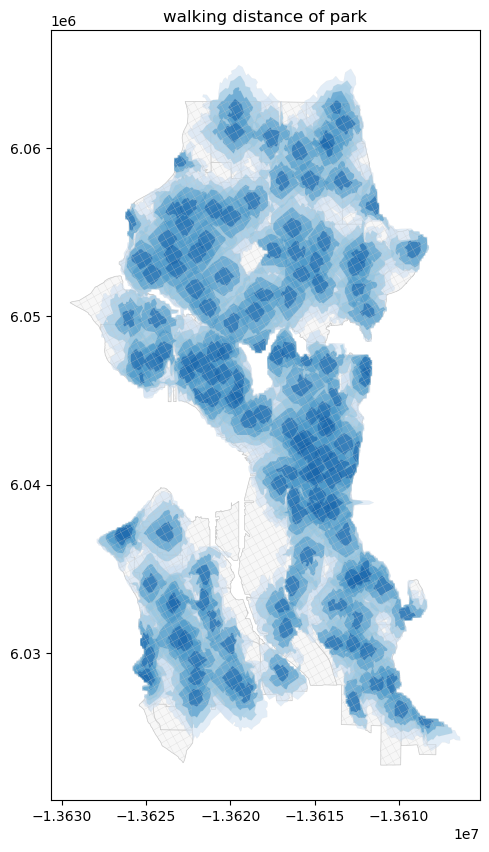

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('walking distance of park')
seattle_boundary.plot(ax=ax, facecolor='#f7f7f7', edgecolor='#cccccc', linewidth=0.5)
intersect_grid_20.plot(ax=ax, facecolor=plt.cm.Blues(0.2), edgecolor='#cccccc', linewidth=0.1, alpha=0.6)
intersect_grid_15.plot(ax=ax, facecolor=plt.cm.Blues(0.4), edgecolor='#cccccc', linewidth=0.1, alpha=0.6)
intersect_grid_10.plot(ax=ax, facecolor=plt.cm.Blues(0.6), edgecolor='#cccccc', linewidth=0.1, alpha=0.6)
intersect_grid_5.plot(ax=ax, facecolor=plt.cm.Blues(0.8), edgecolor='#cccccc', linewidth=0.1, alpha=0.6)
grid_gdf.plot(ax=ax, edgecolor='#cccccc', facecolor='none', linewidth=0.1, alpha=0.8)
print(grid_gdf.crs)

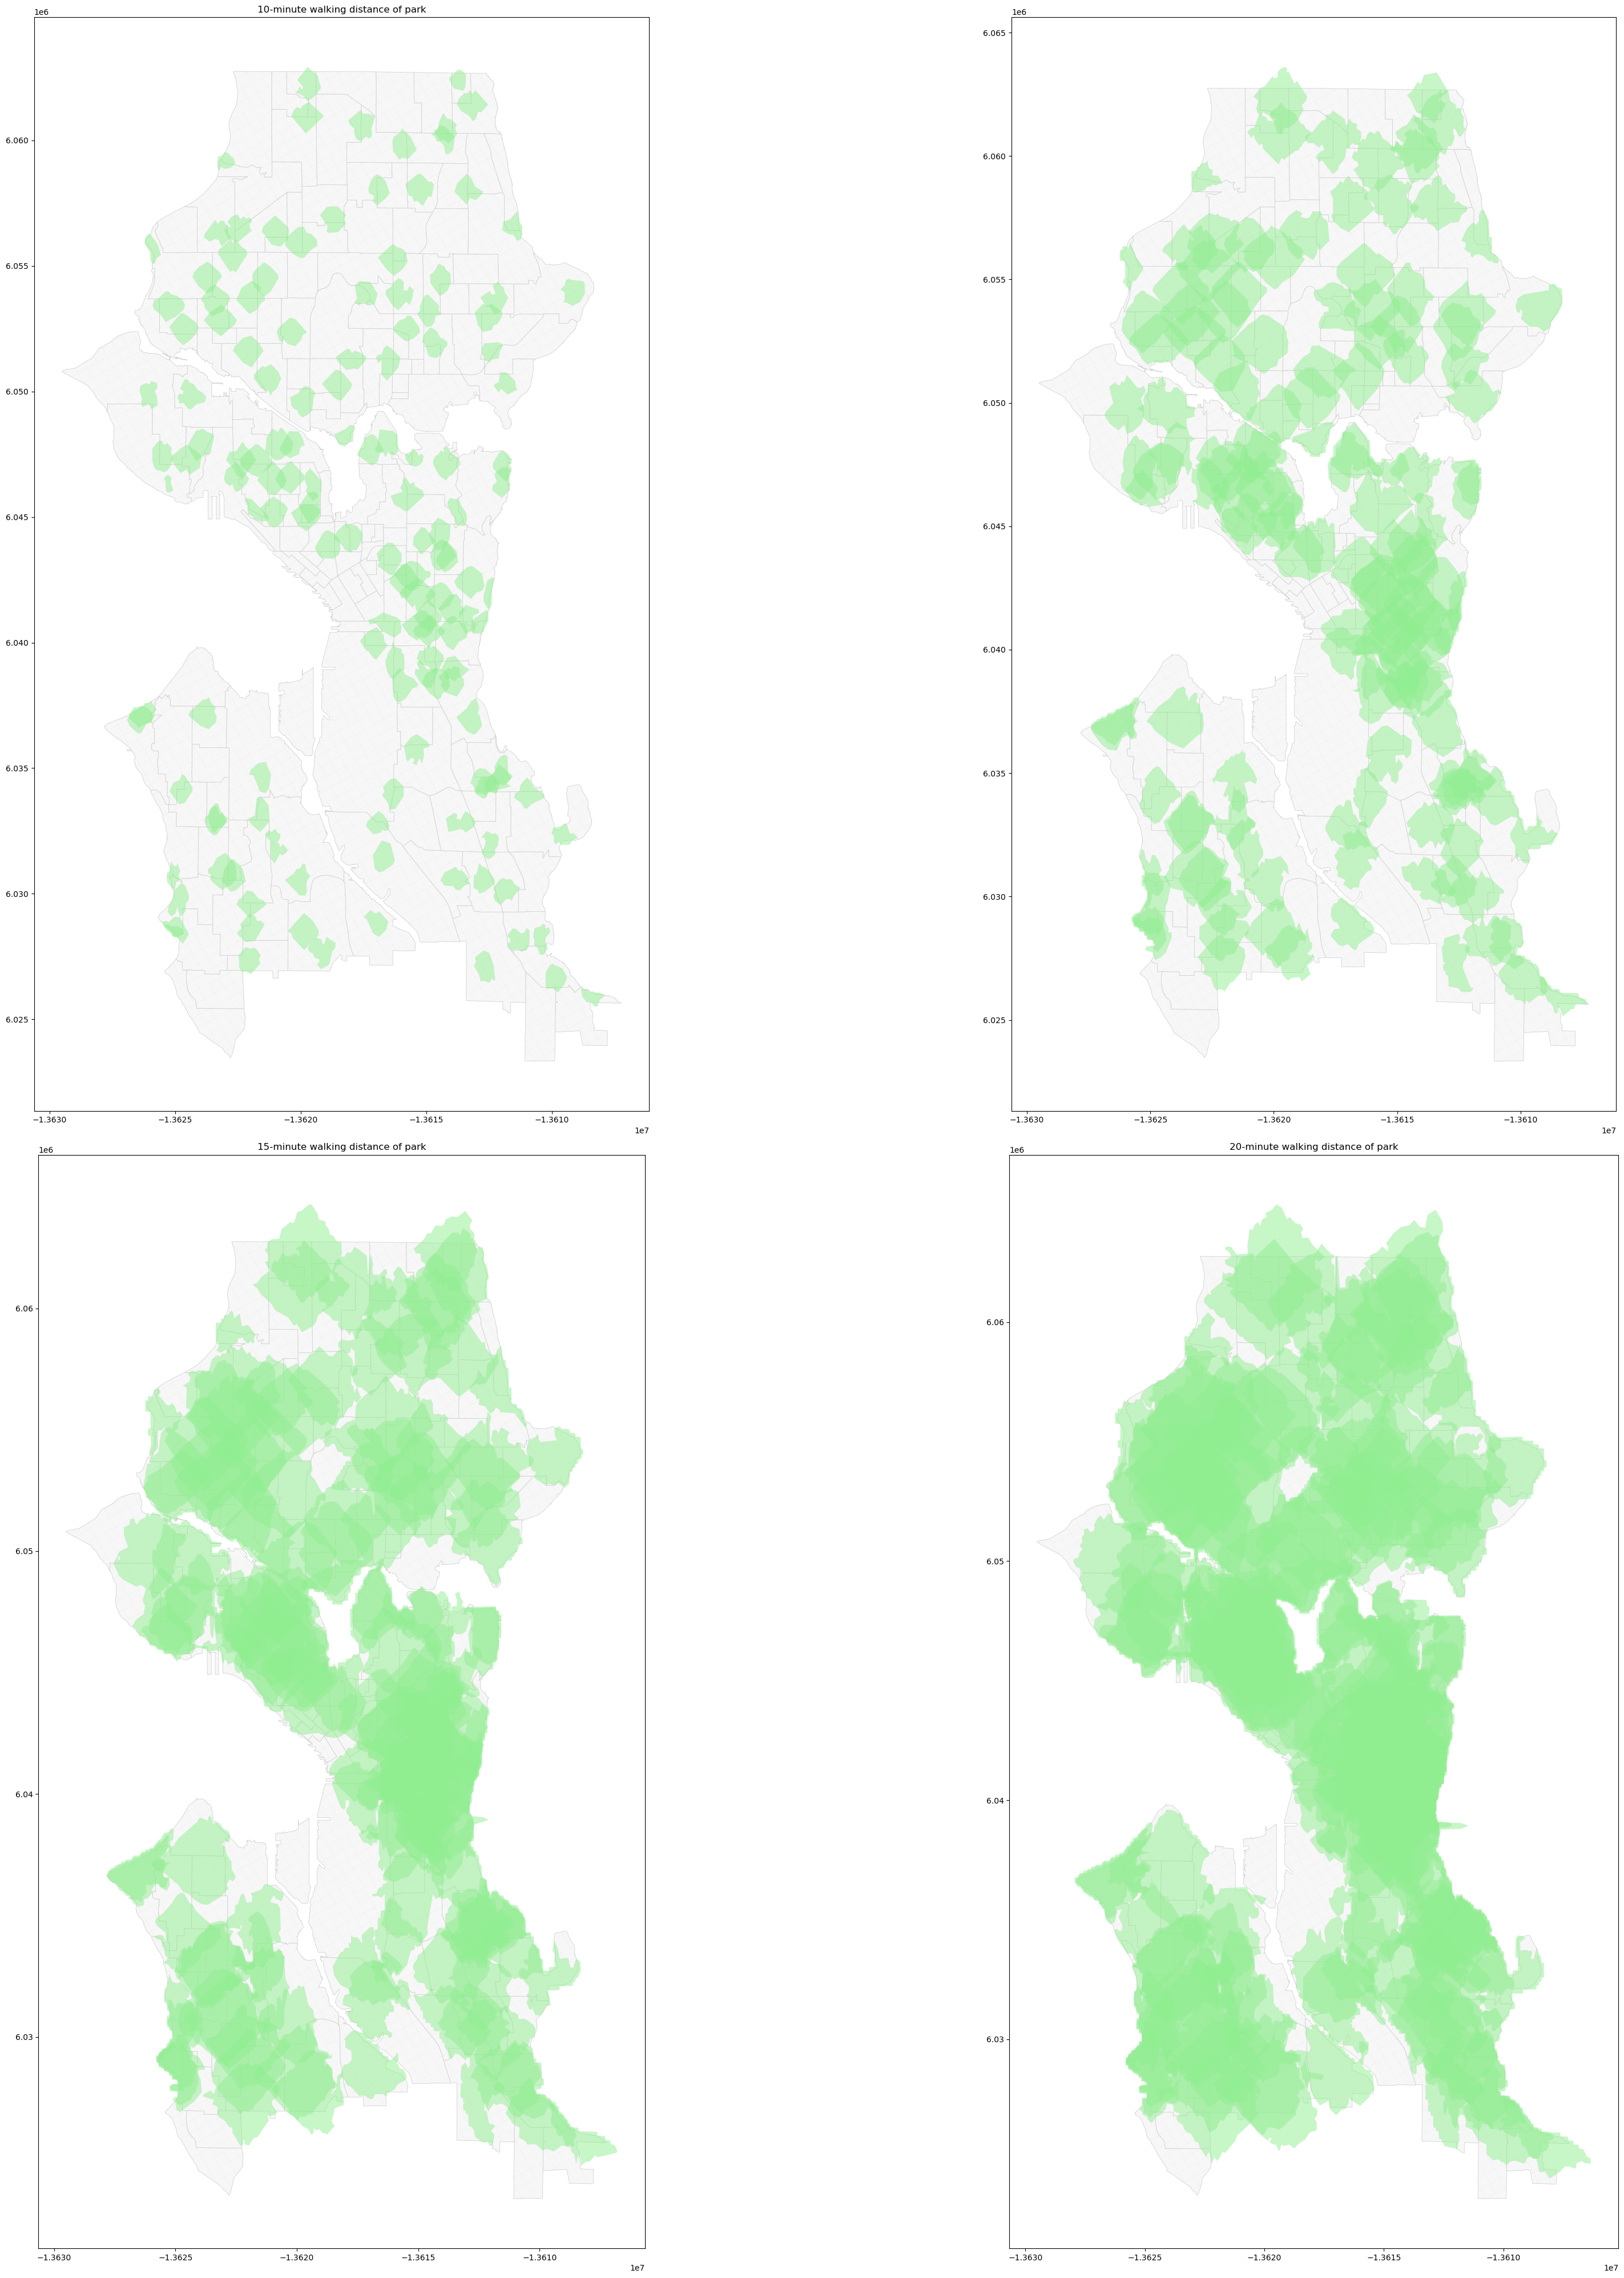

In [14]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# 创建一个 2*2 的 GridSpec 对象
fig = plt.figure(figsize=(40, 40))
gs = GridSpec(2, 2, figure=fig)

# 在指定的位置绘制图形
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('5-minute walking distance of park')
seattle_boundary.plot(ax=ax1, facecolor='#f7f7f7', edgecolor='#cccccc', linewidth=0.5)
grid_gdf.plot(ax=ax1, edgecolor='#cccccc', facecolor='none', linewidth=0.1, alpha=0.3)
intersect_grid_5.plot(ax=ax1, facecolor='lightgreen', edgecolor='#cccccc', linewidth=0.1, alpha=0.5)

ax2 = fig.add_subplot(gs[0, 1:])
ax1.set_title('10-minute walking distance of park')
seattle_boundary.plot(ax=ax2, facecolor='#f7f7f7', edgecolor='#cccccc', linewidth=0.5)
grid_gdf.plot(ax=ax2, edgecolor='#cccccc', facecolor='none', linewidth=0.1, alpha=0.3)
intersect_grid_10.plot(ax=ax2, facecolor='lightgreen', edgecolor='#cccccc', linewidth=0.1, alpha=0.5)

ax3 = fig.add_subplot(gs[1:, 0])
ax3.set_title('15-minute walking distance of park')
seattle_boundary.plot(ax=ax3, facecolor='#f7f7f7', edgecolor='#cccccc', linewidth=0.5)
grid_gdf.plot(ax=ax3, edgecolor='#cccccc', facecolor='none', linewidth=0.1, alpha=0.3)
intersect_grid_15.plot(ax=ax3, facecolor='lightgreen', edgecolor='#cccccc', linewidth=0.1, alpha=0.5)

ax4 = fig.add_subplot(gs[1:, 1:])
ax4.set_title('20-minute walking distance of park')
seattle_boundary.plot(ax=ax4, facecolor='#f7f7f7', edgecolor='#cccccc', linewidth=0.5)
grid_gdf.plot(ax=ax4, edgecolor='#cccccc', facecolor='none', linewidth=0.1, alpha=0.3)
intersect_grid_20.plot(ax=ax4, facecolor='lightgreen', edgecolor='#cccccc', linewidth=0.1, alpha=0.5)

# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()


### 学校

#### 10min步行范围的学校可达性

In [15]:
# 读取学校的数据
schools_gdf = gpd.read_file('Seattle_Public_Schools_Sites.geojson')

# 统一相同的crs
if schools_gdf.crs != grid_gdf.crs:
    schools_gdf = schools_gdf.to_crs(grid_gdf.crs)

schools_gdf_clip = gpd.clip(schools_gdf,seattle_boundary)
schools_gdf_clip.head(3)

OBJECTID_1  OBJECTID  schID          schName         mapLabel       Status  \
2           3         3    264     Rainier View     Rainier View         ELEM   
4           5         5    221          Emerson          Emerson         ELEM   
6           7         7    291  South Shore K-8  South Shore K-8  Option ELEM   

  esmshs                           geometry  
2     ES  POINT (-13610274.057 6023884.827)  
4     ES  POINT (-13609769.121 6026514.487)  
6     ES  POINT (-13611257.794 6027985.217)

In [16]:
# 去除关闭的学校(这属于无效数据)
schools_gdf_clip = schools_gdf_clip[~schools_gdf_clip['Status'].str.contains('Closed')]
schools_gdf_clip.head(3)

OBJECTID_1  OBJECTID  schID          schName         mapLabel       Status  \
2           3         3    264     Rainier View     Rainier View         ELEM   
4           5         5    221          Emerson          Emerson         ELEM   
6           7         7    291  South Shore K-8  South Shore K-8  Option ELEM   

  esmshs                           geometry  
2     ES  POINT (-13610274.057 6023884.827)  
4     ES  POINT (-13609769.121 6026514.487)  
6     ES  POINT (-13611257.794 6027985.217)

In [17]:
# 执行空间连接,找到每个等时线范围内的学校
schools_within_isochrones = gpd.sjoin(schools_gdf_clip,intersect_grid_10,how = 'inner',predicate = 'within')
schools_within_isochrones.head(3)

OBJECTID_1  OBJECTID  schID          schName         mapLabel       Status  \
4           5         5    221          Emerson          Emerson         ELEM   
6           7         7    291  South Shore K-8  South Shore K-8  Option ELEM   
6           7         7    291  South Shore K-8  South Shore K-8  Option ELEM   

  esmshs                           geometry  index_right  
4     ES  POINT (-13609769.121 6026514.487)           24  
6     ES  POINT (-13611257.794 6027985.217)           40  
6     ES  POINT (-13611257.794 6027985.217)          129

在geopandas库的sjoin函数中，predicate参数用于指定空间关系判断条件，其可能结果的含义如下：

intersects：表示相交关系，即两个几何图形至少有一个共同点。这是sjoin函数中predicate参数的默认值 123。

contains：代表包含关系，若b包含a，则意味着a完全在b的内部，且a与b的边界不接触 2。

within：对象的边界和内部只与另一个对象的内部相交（而不是其边界或外部），b.within(a)等价于a.contains(b) 2。

touches：指触摸关系，两个对象至少有一个共同点，并且它们的内部没有与另一个对象的任何部分相交 2。

crosses：表示交叉关系，对象的内部与另一个对象的内部相交，但不包含另一个对象，且相交处的尺寸小于一个对象或另一个对象的尺寸 2。

overlaps：意味着重叠关系，几何图形有多个共同点，但不是所有共同点，且具有相同的维度，并且几何图形内部的交集与几何图形本身具有相同的维度 2。

covers：覆盖关系，一个几何图形覆盖另一个几何图形 3。

covered_by：被覆盖关系，一个几何图形被另一个几何图形覆盖 3。

contains_properly：严格包含关系 3。

In [18]:
# 统计等值范围内学校的数量,上一步骤的作用就是为了获取index_right
school_counts = schools_within_isochrones.groupby('index_right').size()
school_counts

index_right
0      1
1      1
2      1
5      1
8      1
      ..
138    2
140    2
142    1
144    1
149    4
Length: 93, dtype: int64

In [20]:
# 添加统计数量的数据到GeoDataFrame
intersect_grid_10['school_counts'] = intersect_grid_10.index.map(school_counts).fillna(0)
intersect_grid_10.head(3)

geometry  school_counts
0  POLYGON ((-13625698.367 6037804.217, -13625809...            1.0
1  POLYGON ((-13619817.915 6050766.761, -13620046...            1.0
2  POLYGON ((-13624564.801 6053564.309, -13624787...            1.0

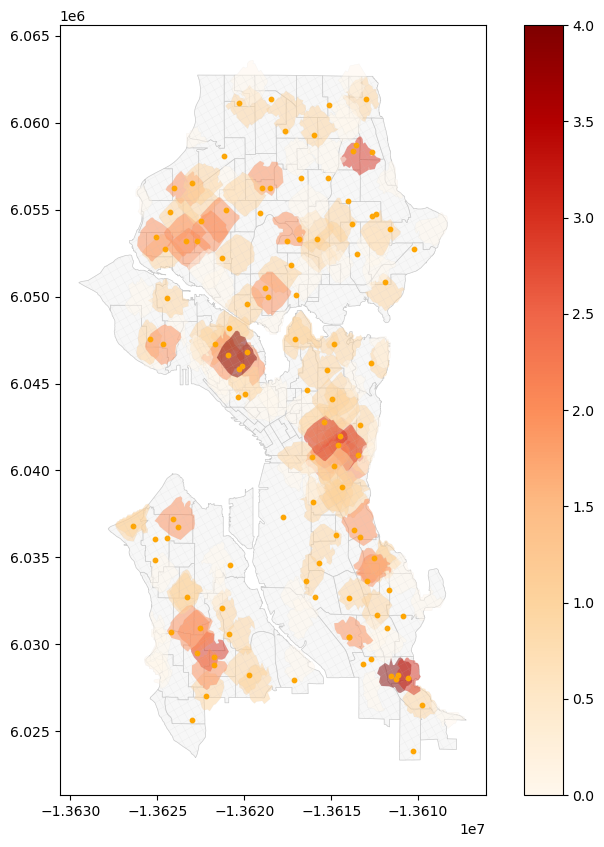

In [22]:
# 创建一个 Matplotlib 图形和轴对象
fig, ax = plt.subplots(figsize=(10, 10))
seattle_boundary.plot(ax=ax, facecolor='#f7f7f7', edgecolor='#cccccc', linewidth=0.5)
# 根据 'school_count' 列的值进行着色，并指定颜色映射
intersect_grid_10.plot(
    ax=ax, 
    column='school_counts',    # 基于 'school_count' 列着色
    cmap='OrRd',
    edgecolor='#cccccc', 
    linewidth=0.1,    
    alpha=0.5,     
    legend=True         
)
schools_gdf_clip.plot(ax=ax, color='orange', markersize=10)
grid_gdf.plot(ax=ax, edgecolor='#cccccc', facecolor='none', linewidth=0.1, alpha=0.3)
# 显示图形
plt.show()

#### 20min步行范围的学校可达性

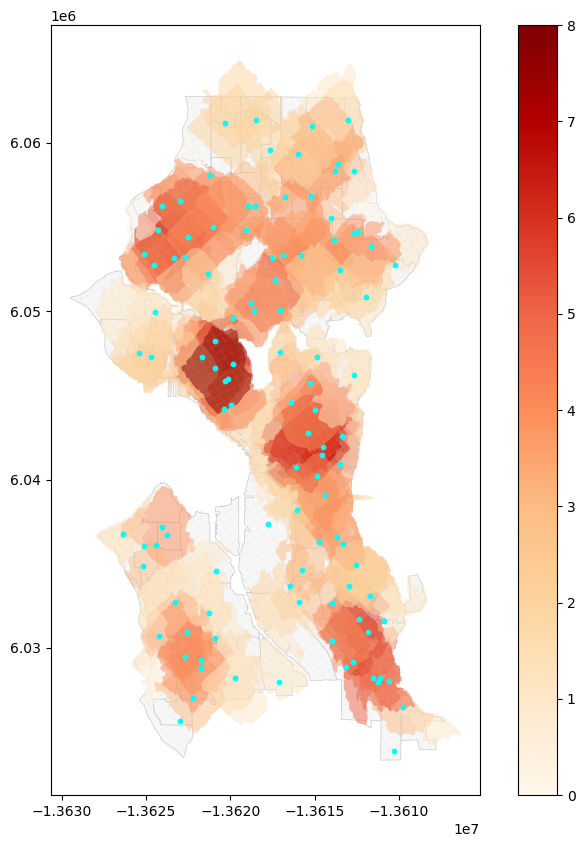

In [26]:
# 执行空间连接,找到20min等时线范围内的学校
schools_within_isochrones_20 = gpd.sjoin(schools_gdf_clip,intersect_grid_20,how = 'inner',predicate = 'within')

# 统计等值范围内学校的数量
school_counts_20 = schools_within_isochrones_20.groupby('index_right').size()
school_counts_20

# 添加统计数量的数据到GeoDataFrame
intersect_grid_20['school_counts_20'] = intersect_grid_20.index.map(school_counts_20).fillna(0)

# 创建一个 Matplotlib 图形和轴对象
fig, ax = plt.subplots(figsize=(10, 10))
seattle_boundary.plot(ax=ax, facecolor='#f7f7f7', edgecolor='#cccccc', linewidth=0.5)

# 根据 'school_count' 列的值进行着色，并指定颜色映射
intersect_grid_20.plot(
    ax=ax, 
    column='school_counts_20',    # 基于 'school_count' 列着色
    cmap='OrRd',
    edgecolor='#cccccc', 
    linewidth=0.1,    
    alpha=0.5,     
    legend=True         
)
schools_gdf_clip.plot(ax=ax, color='cyan', markersize=10)
grid_gdf.plot(ax=ax, edgecolor='#cccccc', facecolor='none', linewidth=0.1, alpha=0.3)
# 显示图形
plt.show()

### 定义其他设施的函数

In [28]:
def CalculateAmentityCountinisochrones(amentity_gdf_clip,amentity_name,intersect_grid):
    # 执行空间连接
    amentity_within_isochrones = gpd.sjoin(amentity_gdf_clip,intersect_grid,how = 'inner',predicate = 'within')

    # 统计等值范围内学校的数量
    amentity_counts = amentity_within_isochrones.groupby('index_right').size()
    amentity_counts

    # 添加统计数量的数据到GeoDataFrame
    intersect_grid['amentity_counts'] = intersect_grid.index.map(amentity_counts).fillna(0)
    
    return intersect_grid

### 娱乐设施

In [29]:
# 读取数据
amentity_gdf = gpd.read_file('Recreation_Structures.geojson')
    
# 确保数据的GeoDataFrame和等时线的GeoDataFrame使用相同的CRS
if amentity_gdf.crs != grid_gdf.crs:
    amentity_gdf = amentity_gdf.to_crs(grid_gdf.crs)

amentity_gdf_clip = gpd.clip(amentity_gdf,seattle_boundary)

amentity_gdf_clip.head()

OBJECTID                    PERMANENT_IDENTIFIER  \
22665   1462176  {6EA93D1F-3E77-444B-AB6F-598B86572877}   
23741   1461035  {D130A096-8A95-40A6-9A8E-A34872EC6350}   

                             SOURCE_FEATUREID  \
22665  {CE765746-FF1F-4739-85DE-24FD4CABE089}   
23741  {8C52A314-7A5B-4EF0-B1B0-5E6A5F79AB14}   

                             SOURCE_DATASETID  \
22665  {AF1516DD-E5E0-4753-A4F4-C9FCEAB3DA24}   
23741  {AF1516DD-E5E0-4753-A4F4-C9FCEAB3DA24}   

                                         SOURCE_DATADESC  \
22665  PW Region National Park Service points of inte...   
23741  PW Region National Park Service points of inte...   

                                       SOURCE_ORIGINATOR  DATA_SECURITY  \
22665  Department of the Interior, National Park Serv...              5   
23741  Department of the Interior, National Park Serv...              5   

      DISTRIBUTION_POLICY                       LOADDATE  FTYPE  ...  \
22665                  E4  Wed, 17 Aug 2022 10:02:09 GMT    820  ...   
23741                  E4  Wed, 17 Aug 2022 10:02:09 GMT    830  ...   

       ADMINTYPE ADDRESSBUILDINGNAME  ADDRESS  CITY  STATE ZIPCODE GNIS_ID  \
22665        1.0                None     None  None     WA    None    None   
23741        1.0                None     None  None     WA    None    None   

      FOOT_ID COMPLEX_ID                           geometry  
22665    None       None  POINT (-13617934.109 6040461.912)  
23741    None       None  POINT (-13617671.053 6043924.014)  

[2 rows x 24 columns]

In [36]:
# 10min娱乐设施可达性
intersect_grid_10x = CalculateAmentityCountinisochrones(
    amentity_gdf_clip = amentity_gdf_clip,
    amentity_name = 'Recreation',
    intersect_grid = intersect_grid_10)

intersect_grid_10x.head()

geometry  school_counts  \
0  POLYGON ((-13625698.367 6037804.217, -13625809...            1.0   
1  POLYGON ((-13619817.915 6050766.761, -13620046...            1.0   
2  POLYGON ((-13624564.801 6053564.309, -13624787...            1.0   
3  POLYGON ((-13623936.736 6049221.168, -13624270...            0.0   
4  POLYGON ((-13620967.957 6046336.976, -13621190...            0.0   

   amentity_counts  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

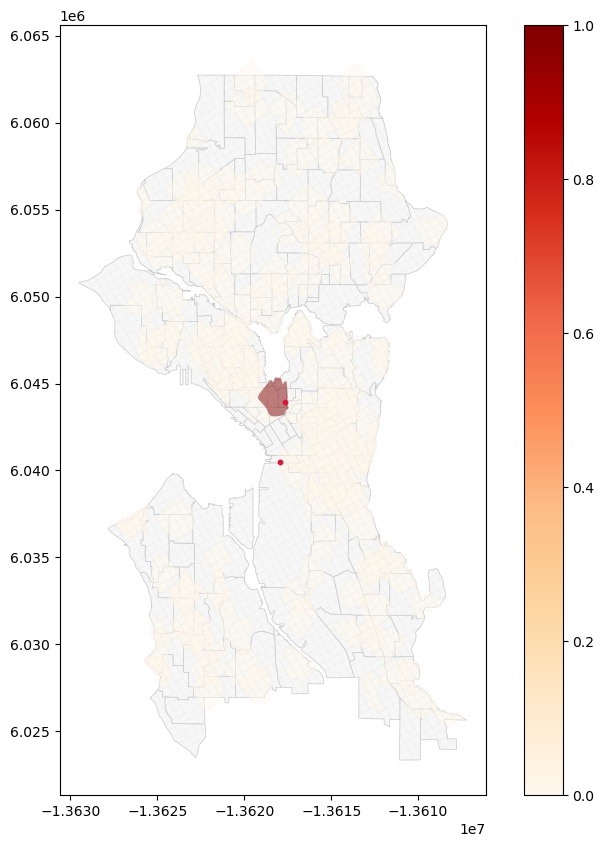

In [33]:
# 创建一个 Matplotlib 图形和轴对象
fig, ax = plt.subplots(figsize=(10, 10))
seattle_boundary.plot(ax=ax, facecolor='#f7f7f7', edgecolor='#cccccc', linewidth=0.5)
# 根据 'amentity_count' 列的值进行着色，并指定颜色映射
intersect_grid_10x.plot(
    ax=ax, 
    column='amentity_counts',    
    cmap='OrRd',
    edgecolor='#cccccc', 
    linewidth=0.1,  
    alpha=0.5, 
    legend=True 
)
amentity_gdf_clip.plot(ax=ax, color='crimson', markersize=10)
grid_gdf.plot(ax=ax, edgecolor='#cccccc', facecolor='none', linewidth=0.1, alpha=0.3)
# 显示图形
plt.show()

### 车站

In [34]:
# 读取车展
metro_gdf = gpd.read_file('King_County_Metro_Transit_Stops.geojson')
    
# 确保数据的GeoDataFrame和等时线的GeoDataFrame使用相同的CRS
if metro_gdf.crs != grid_gdf.crs:
    metro_gdf = metro_gdf.to_crs(grid_gdf.crs)

metro_gdf_clip = gpd.clip(metro_gdf,seattle_boundary)

metro_gdf_clip.head(5)

OBJECTID_1  OBJECTID  CHANGE_NUM  MINOR_CHAN ACCESSIBIL ACCESSORY_  \
13132       13133     13133         155           4        YES       None   
19051       19052     19052         155           5        YES       None   
13123       13124     13124         155           4        YES       None   
20216       20217     20217         155           5        YES       None   
843           844       844         155           4        YES       None   

       STOP_ID  TRANS_LINK STOP_STATU STOP_TYPE  ...    ON_STREET_  \
13132    55380      127316        ACT       REG  ...  Beacon Ave S   
19051    55380      127316        ACT       REG  ...  Beacon Ave S   
13123    55370       48188        ACT       REG  ...    59th Ave S   
20216    55370       48188        ACT       REG  ...    59th Ave S   
843      55430       51575        ACT       REG  ...    51st Ave S   

        ROUTESIGN ROUTESIGN_ SIGN_MOUNT   SIGNPOST    SIGNPOST_A SCHEDULE_H  \
13132  A1 <=2 rts        KCM     Toward  2in metal  Cncrt-asphlt     Single   
19051  A1 <=2 rts        KCM     Toward  2in metal  Cncrt-asphlt     Single   
13123  A1 <=2 rts        KCM       Away  2in metal   Cncrt-earth       None   
20216  A1 <=2 rts        KCM       Away  2in metal   Cncrt-earth       None   
843    A1 <=2 rts        KCM       Away  2in metal   Cncrt-earth       None   

      NUM_SHELTE  GISOBJID                           geometry  
13132          1      4715  POINT (-13609919.788 6023459.351)  
19051          1      4715  POINT (-13609919.788 6023459.351)  
13123          0      4707  POINT (-13609888.325 6023633.418)  
20216          0      4707  POINT (-13609888.325 6023633.418)  
843            0      4720   POINT (-13611040.48 6024869.901)  

[5 rows x 58 columns]

In [37]:
# 10min娱乐设施可达性
intersect_grid_10x = CalculateAmentityCountinisochrones(
    amentity_gdf_clip = metro_gdf_clip,
    amentity_name = 'Metro_Stop',
    intersect_grid = intersect_grid_10)

intersect_grid_10x.head()

geometry  school_counts  \
0  POLYGON ((-13625698.367 6037804.217, -13625809...            1.0   
1  POLYGON ((-13619817.915 6050766.761, -13620046...            1.0   
2  POLYGON ((-13624564.801 6053564.309, -13624787...            1.0   
3  POLYGON ((-13623936.736 6049221.168, -13624270...            0.0   
4  POLYGON ((-13620967.957 6046336.976, -13621190...            0.0   

   amentity_counts  
0             50.0  
1            144.0  
2             76.0  
3             54.0  
4            116.0

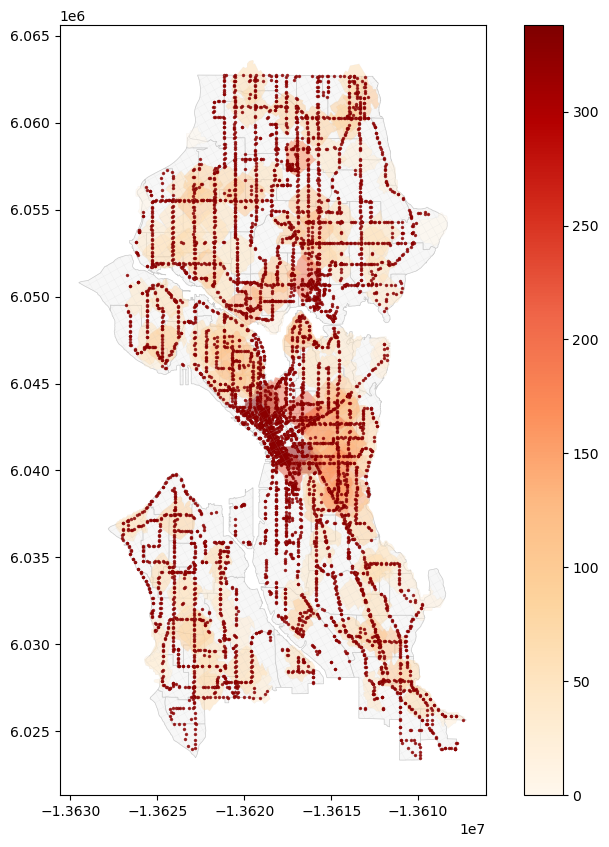

In [54]:
# 创建一个 Matplotlib 图形和轴对象
fig, ax = plt.subplots(figsize=(10, 10))
seattle_boundary.plot(ax=ax, facecolor='#f7f7f7', edgecolor='#cccccc', linewidth=0.5)
# 根据 'amentity_count' 列的值进行着色，并指定颜色映射
intersect_grid_10x.plot(
    ax=ax, 
    column='amentity_counts',    
    cmap='OrRd',
    edgecolor='#cccccc', 
    linewidth=0.1,  
    alpha=0.5, 
    legend=True 
)
metro_gdf_clip.plot(ax=ax, color='darkred', markersize=2, alpha=0.5)
grid_gdf.plot(ax=ax, edgecolor='#cccccc', facecolor='none', linewidth=0.1, alpha=0.3)
# 显示图形
plt.show()

### 工作机会

In [42]:
# 读取工作机会数据
amentity_gdf = gpd.read_file('Business_Points_of_Interest_Seattle1.geojson')
    
# 确保数据的GeoDataFrame和等时线的GeoDataFrame使用相同的CRS
if amentity_gdf.crs != grid_gdf.crs:
    amentity_gdf = amentity_gdf.to_crs(grid_gdf.crs)

amentity_gdf_clip = gpd.clip(amentity_gdf,seattle_boundary)

amentity_gdf_clip.head()

OBJECTID                             CONAME              ADDR     CITY  \
1187      1188                      Ideoclick Inc         1st Ave S  Seattle   
1329      1330                  Code Systems Corp         1st Ave S  Seattle   
926        927  Graham Construction & Engineering         1st Ave S  Seattle   
3941      3942              Sice Agencia Chile Sa  Occidental Ave S  Seattle   
1911      1912           Five Six Eight First Ave         1st Ave S  Seattle   

      STATE_NAME STATE    ZIP  ZIP4     NAICS                     NAICS_ALL  \
1187  Washington    WA  98104  4420  51821013                      51821013   
1329  Washington    WA  98104  4420  51321005                      51321005   
926   Washington    WA  98104  4420  23611512  23611512, 23611505, 23799012   
3941  Washington    WA  98104  2869  99999004                      99999004   
1911  Washington    WA  98104  4419  99999004                      99999004   

      ...     SOURCE                          ESRI_PID  \
1187  ...  Data Axle  853edb450c88380e121dde3faa397513   
1329  ...  Data Axle  c0c4e438b4811963fdd9d9762d060b7f   
926   ...  Data Axle  c7559040fecc57731ecb483b0126b15f   
3941  ...  Data Axle  3fe875f7c4ccdab459c1890f23cc8dcc   
1911  ...  Data Axle  814e6019f4011b4684243e8021abe270   

                            DESC_   LATITUDE   LONGITUDE  \
1187  CONAME, Seattle, Washington  47.596311 -122.333688   
1329  CONAME, Seattle, Washington  47.596311 -122.333688   
926   CONAME, Seattle, Washington  47.596311 -122.333688   
3941  CONAME, Seattle, Washington  47.596311 -122.333688   
1911  CONAME, Seattle, Washington  47.596311 -122.333688   

                       CreationDate                  Creator  \
1187  Tue, 12 Dec 2023 12:49:55 GMT  ULI_Hines_Admin_Support   
1329  Tue, 12 Dec 2023 12:49:55 GMT  ULI_Hines_Admin_Support   
926   Tue, 12 Dec 2023 12:49:55 GMT  ULI_Hines_Admin_Support   
3941  Tue, 12 Dec 2023 12:49:55 GMT  ULI_Hines_Admin_Support   
1911  Tue, 12 Dec 2023 12:49:55 GMT  ULI_Hines_Admin_Support   

                           EditDate                   Editor  \
1187  Tue, 12 Dec 2023 12:49:55 GMT  ULI_Hines_Admin_Support   
1329  Tue, 12 Dec 2023 12:49:55 GMT  ULI_Hines_Admin_Support   
926   Tue, 12 Dec 2023 12:49:55 GMT  ULI_Hines_Admin_Support   
3941  Tue, 12 Dec 2023 12:49:55 GMT  ULI_Hines_Admin_Support   
1911  Tue, 12 Dec 2023 12:49:55 GMT  ULI_Hines_Admin_Support   

                               geometry  
1187  POINT (-13618123.855 6039956.219)  
1329  POINT (-13618123.855 6039956.219)  
926   POINT (-13618123.855 6039956.219)  
3941  POINT (-13618123.855 6039956.219)  
1911  POINT (-13618123.855 6039956.219)  

[5 rows x 31 columns]

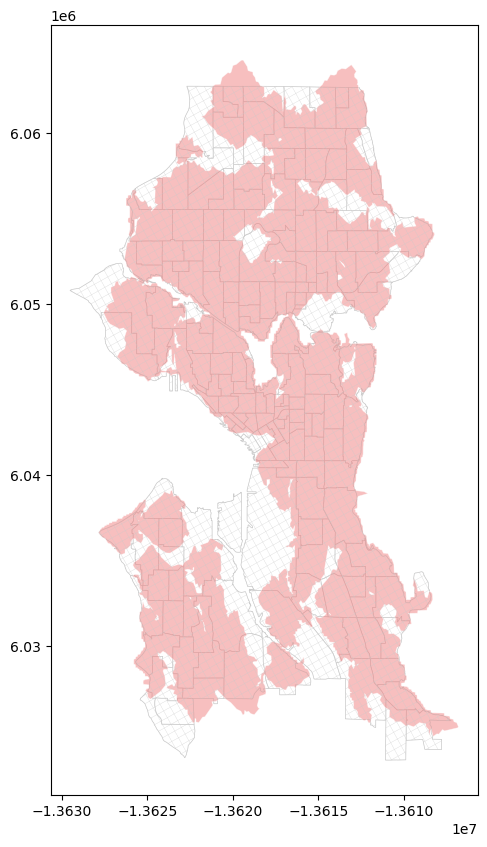

In [63]:
from shapely.ops import unary_union
# 获得所有服务范围的并集
union_polygon = unary_union(intersect_grid_15.geometry)
# 创建一个 GeoDataFrame 来存储并集
union_gdf = gpd.GeoDataFrame(geometry=[union_polygon], crs=intersect_grid_15.crs)

# 绘制并集
fig, ax = plt.subplots(figsize=(10, 10))
union_gdf.plot(ax=ax, facecolor='lightcoral', edgecolor='white', alpha=0.5, linewidth=0.5,zorder = 10)
grid_gdf.plot(ax=ax, edgecolor='#cccccc', facecolor='none', linewidth=0.1, alpha=1,zorder = 10)
seattle_boundary.plot(ax=ax, facecolor='white', edgecolor='#cccccc', linewidth=0.5,zorder = 5)
plt.show()

### 人口公平性

In [57]:
# 加载数据
shapefile_path = '2010_Census_Tract_Seattle_-_Population_Statistics.geojson'
census_gdf = gpd.read_file(shapefile_path)

# 确保坐标系一致
census_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)
census_gdf['pop_density'] = (census_gdf['Total_Population'] / census_gdf['ACRES_TOTAL'])

total_population = census_gdf['Total_Population'].sum()
total_children = census_gdf['Male_under_5_years'].sum() + census_gdf['Female_under_5_years'].sum()
children_ratio = total_children / total_population

# 转换坐标系
census_gdf = census_gdf.to_crs(union_gdf.crs)

joined_gdf = gpd.sjoin(census_gdf, union_gdf,how="inner", predicate="within")
intersected_census = joined_gdf.dropna(subset=['index_right'])

total_population_served = intersected_census['Total_Population'].sum()
total_children_served = intersected_census['Male_under_5_years'].sum() + intersected_census['Female_under_5_years'].sum()
children_ratio_served = total_children_served / total_population_served

print(children_ratio_served)
print(total_population)

0.047072509587607635
608660


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_13939/299702336.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


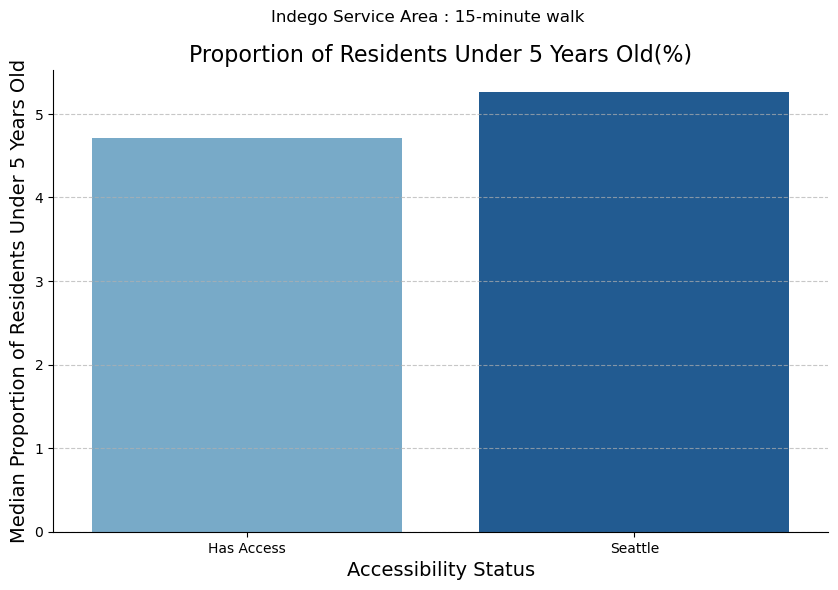

In [61]:
data = {
    'Category': ['Has Access', 'Seattle'],
    'Mean_Pct_Children': [children_ratio_served * 100, children_ratio * 100]
}
grid_equity_summary = pd.DataFrame(data)

# 设置颜色调色板
blue_palette = sns.color_palette("Blues", n_colors=5)

# 绘制条形图
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data,
    x='Category',
    y='Mean_Pct_Children',
    palette=[blue_palette[2], blue_palette[4]],  # 使用蓝色调色板的指定颜色
    linewidth=0.5,
    legend=False  # 不显示图例
)

# 设置图表标题和标签
plt.title('Proportion of Residents Under 5 Years Old(%)', fontsize=16)
plt.suptitle('Indego Service Area : 15-minute walk', fontsize=12)
plt.xlabel('Accessibility Status', fontsize=14)
plt.ylabel('Median Proportion of Residents Under 5 Years Old', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()
# 显示图表
plt.show()


### spatial lag

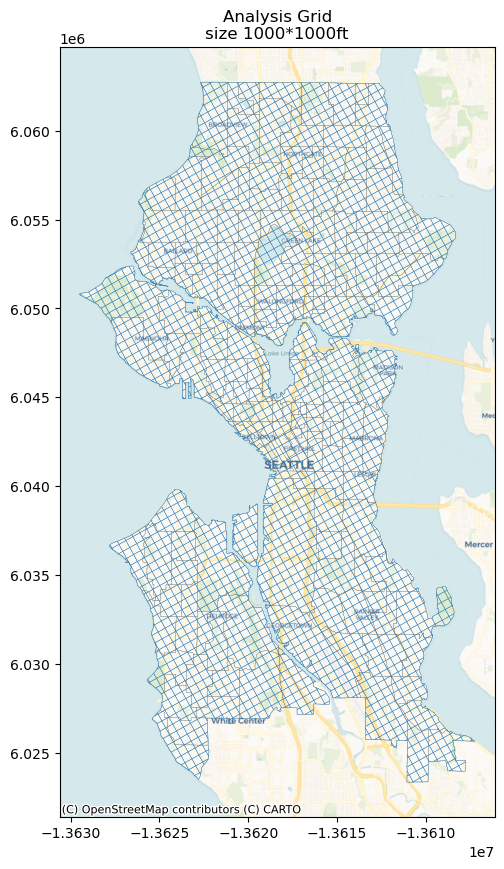

In [1]:
# Required Libraries
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from contextily import add_basemap
import contextily as cx

# 加载seattle boundary
seattle_boundary = gpd.read_file("Seattle_City_Boundary.geojson")
seattle_boundary = seattle_boundary.to_crs(epsg=2272)  # Transform to a projection in feet

# 设置grid大小
grid_size = 1000  # 1000 feet

# 在seattle boundary 绘制 grids
minx, miny, maxx, maxy = seattle_boundary.total_bounds
x_range = maxx - minx
y_range = maxy - miny

# 绘制grids
rows = int(y_range / grid_size)
cols = int(x_range / grid_size)
grid = []
for i in range(cols + 1):
    for j in range(rows + 1):
        grid.append(box(minx + i * grid_size, miny + j * grid_size, minx + (i + 1) * grid_size, miny + (j + 1) * grid_size))


# 选择适合的投影坐标系统
projected_crs = '3857'  # Web Mercator 投影
# 确保 CRS 转换

grid_gdf = gpd.GeoDataFrame(geometry=grid, crs=seattle_boundary.crs)
grid_gdf = gpd.clip(grid_gdf, seattle_boundary)
grid_gdf = grid_gdf.to_crs(epsg=projected_crs)
seattle_boundary = seattle_boundary.to_crs(epsg=projected_crs)

# 计算几何中心
centroids = grid_gdf.centroid

# Plot the grid
fig, ax = plt.subplots(figsize=(10, 10))

seattle_boundary.plot(ax=ax, color='none', edgecolor='black',linewidth=0.1)
grid_gdf.plot(ax=ax, facecolor='none', edgecolor='#3182bd', linewidth=0.3)
# Add basemap
cx.add_basemap(ax, crs=grid_gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom=12)

plt.title("Analysis Grid\nsize 1000*1000ft")
plt.show()

In [3]:
parks = gpd.read_file('SeattleParkPoints.geojson')

# 转换坐标系统CRS
parks_proj = parks.to_crs(epsg=projected_crs)  

#### 相同方法计算人口密度

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors
import contextily as cx
from libpysal.weights import KNN
from pysal.model.spreg import ML_Lag

将shapley point转换成正常的点坐标

In [7]:
# 计算grid中心点
grid_gdf['centroid'] = grid_gdf.geometry.centroid
print(grid_gdf['centroid'])
grid_centroids = np.array(list(grid_gdf['centroid'].apply(lambda geom:(geom.x,geom.y))))
grid_centroids
# apply 方法会对 grid_gdf['centroid'] 列中的每个 Point 对象应用 lambda geom:(geom.x,geom.y) 函数。
# 该函数接受一个 Point 对象 geom 作为输入，然后返回一个包含该点的 x 和 y 坐标的元组 (geom.x, geom.y)。

2852    POINT (-13607929.576 6024182.438)
2853    POINT (-13608073.372 6024456.949)
2945     POINT (-13607794.62 6024535.642)
2854    POINT (-13608434.294 6024924.274)
3038    POINT (-13607437.757 6025659.083)
                      ...                
4503     POINT (-13620017.517 6062062.84)
4688     POINT (-13619473.878 6062687.24)
4504     POINT (-13620234.83 6062455.588)
4596    POINT (-13619836.782 6062600.019)
4505    POINT (-13620458.835 6062673.503)
Name: centroid, Length: 2677, dtype: geometry


array([[-13607929.57625651,   6024182.43845768],
       [-13608073.37177455,   6024456.94855136],
       [-13607794.62028457,   6024535.6421572 ],
       ...,
       [-13620234.83019885,   6062455.58808801],
       [-13619836.78185156,   6062600.01937097],
       [-13620458.83529403,   6062673.50292796]])

In [8]:
# 读取人口普查数据GeoJson
census_file = '2010_Census_Tract_Seattle_-_Population_Statistics.geojson'
census_gdf = gpd.read_file(census_file)
census_gdf_proj = census_gdf.to_crs(epsg = projected_crs)
census_gdf_proj.head(3)

OBJECTID      GEOID10  TRACT NAME10  ACRES_TOTAL ACRES_LAND ACRES_WATER  \
0         1  53033002500   2500     25   243.219083       None        None   
1         2  53033002600   2600     26   307.584420       None        None   
2         3  53033005600   5600     56   737.511727       None        None   

  GEO_TYPE  Total_Population  Population_Not_Hispanic_or_Lati  ...  \
0    Tract              2802                             2682  ...   
1    Tract              4660                             4449  ...   
2    Tract              6382                             6216  ...   

   Male_Person_of_Color_5_17_years  Female_Person_of_Color_5_17_yea  \
0                               40                               49   
1                               70                               68   
2                               82                               72   

   Male_Person_of_Color_65_and_ove  Female_Person_of_Color_65_and_o  \
0                               16                               20   
1                               15                               19   
2                               21                               40   

   Total_Person_of_Color  DIVERSITY_INDEX  POP_UNDER_18   Shape__Area  \
0                    551               34           521  1.059462e+07   
1                    862               33           892  1.339838e+07   
2                    732               21          1446  3.212601e+07   

   Shape__Length                                           geometry  
0   16442.968402  POLYGON ((-13613930.964 6055474.802, -13613933...  
1   15936.137058  POLYGON ((-13615283.162 6055487.697, -13615256...  
2   30337.294354  POLYGON ((-13624726.147 6047099.352, -13624726...  

[3 rows x 179 columns]

In [10]:
# 计算人口密度
census_gdf_proj['pop_density'] = census_gdf_proj['Total_Population']/census_gdf_proj['ACRES_TOTAL']
census_gdf_proj.head(3)

OBJECTID      GEOID10  TRACT NAME10  ACRES_TOTAL ACRES_LAND ACRES_WATER  \
0         1  53033002500   2500     25   243.219083       None        None   
1         2  53033002600   2600     26   307.584420       None        None   
2         3  53033005600   5600     56   737.511727       None        None   

  GEO_TYPE  Total_Population  Population_Not_Hispanic_or_Lati  ...  \
0    Tract              2802                             2682  ...   
1    Tract              4660                             4449  ...   
2    Tract              6382                             6216  ...   

   Female_Person_of_Color_5_17_yea  Male_Person_of_Color_65_and_ove  \
0                               49                               16   
1                               68                               15   
2                               72                               21   

   Female_Person_of_Color_65_and_o  Total_Person_of_Color  DIVERSITY_INDEX  \
0                               20                    551               34   
1                               19                    862               33   
2                               40                    732               21   

   POP_UNDER_18   Shape__Area  Shape__Length  \
0           521  1.059462e+07   16442.968402   
1           892  1.339838e+07   15936.137058   
2          1446  3.212601e+07   30337.294354   

                                            geometry  pop_density  
0  POLYGON ((-13613930.964 6055474.802, -13613933...    11.520478  
1  POLYGON ((-13615283.162 6055487.697, -13615256...    15.150312  
2  POLYGON ((-13624726.147 6047099.352, -13624726...     8.653422  

[3 rows x 180 columns]

In [15]:
# 使用空间连接 + 聚合操作 -> 每个格栅的人口密度
census_join = gpd.sjoin(grid_gdf,census_gdf_proj,how = 'left', predicate = 'intersects')
census_join.head(3)

geometry  \
2852  POLYGON ((-13608159.542 6024257.989, -13607787...   
2852  POLYGON ((-13608159.542 6024257.989, -13607787...   
2853  POLYGON ((-13607787.488 6024509.448, -13607787...   

                               centroid  index_right  OBJECTID      GEOID10  \
2852  POINT (-13607929.576 6024182.438)        130.0     131.0  53033026001   
2852  POINT (-13607929.576 6024182.438)        134.0     135.0  53033011900   
2853  POINT (-13608073.372 6024456.949)        130.0     131.0  53033026001   

        TRACT  NAME10  ACRES_TOTAL ACRES_LAND ACRES_WATER  ...  \
2852  26001.0  260.01    14.999770       None        None  ...   
2852  11900.0     119   773.478079       None        None  ...   
2853  26001.0  260.01    14.999770       None        None  ...   

     Male_Person_of_Color_5_17_years  Female_Person_of_Color_5_17_yea  \
2852                             8.0                              9.0   
2852                           565.0                            459.0   
2853                             8.0                              9.0   

      Male_Person_of_Color_65_and_ove  Female_Person_of_Color_65_and_o  \
2852                              2.0                              2.0   
2852                            266.0                            298.0   
2853                              2.0                              2.0   

      Total_Person_of_Color  DIVERSITY_INDEX  POP_UNDER_18   Shape__Area  \
2852                   66.0             74.0          25.0  6.533900e+05   
2852                 5249.0             75.0        1578.0  3.369271e+07   
2853                   66.0             74.0          25.0  6.533900e+05   

      Shape__Length  pop_density  
2852    8005.859069     7.066775  
2852   41622.056980     9.189659  
2853    8005.859069     7.066775  

[3 rows x 182 columns]

In [17]:
grid_pop_density = census_join.groupby(census_join.index)['pop_density'].mean()

In [18]:
grid_pop_density

16       6.348656
17       6.348656
18       6.348656
19       6.348656
20       7.855827
          ...    
5873    13.689276
5874    13.689276
5875    13.689276
5876    13.689276
5877    13.689276
Name: pop_density, Length: 2677, dtype: float64

In [19]:
# 将结果赋值回原始的 grid_gdf
grid_gdf['pop_density'] = grid_gdf.index.map(grid_pop_density)
grid_gdf.head()

geometry  \
2852  POLYGON ((-13608159.542 6024257.989, -13607787...   
2853  POLYGON ((-13607787.488 6024509.448, -13607787...   
2945  POLYGON ((-13607809.247 6024549.043, -13607787...   
2854  POLYGON ((-13608375.281 6024650.517, -13608591...   
3038  POLYGON ((-13607416.937 6025692.292, -13607389...   

                               centroid  pop_density  
2852  POINT (-13607929.576 6024182.438)     8.128217  
2853  POINT (-13608073.372 6024456.949)     8.128217  
2945   POINT (-13607794.62 6024535.642)     7.066775  
2854  POINT (-13608434.294 6024924.274)     8.128217  
3038  POINT (-13607437.757 6025659.083)     9.189659

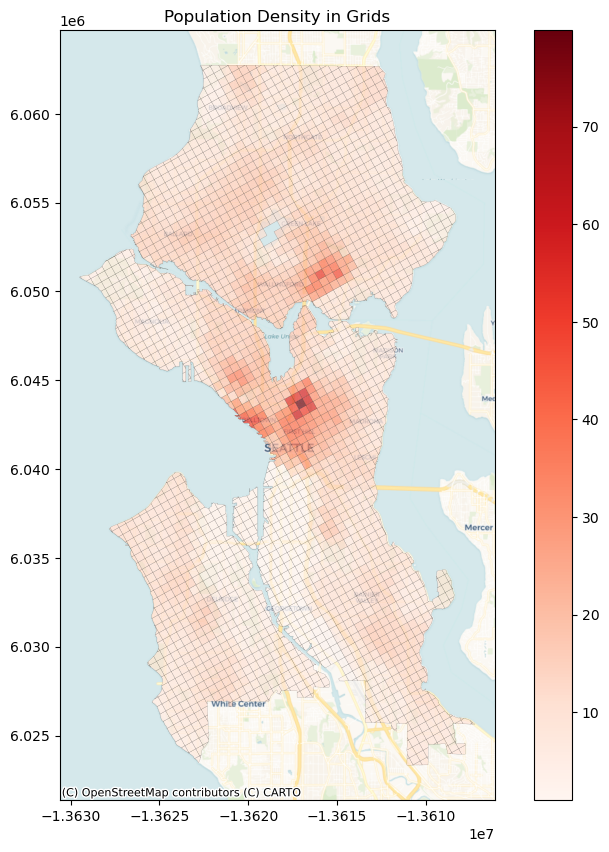

In [21]:
# 绘制
fig, ax = plt.subplots(figsize=(10, 10))
grid_gdf.plot(
    ax=ax, 
    column='pop_density',
    cmap='Reds',
    edgecolor='black',
    linewidth=0.1, 
    alpha=0.7,
    legend=True 
)
plt.title("Population Density in Grids")
cx.add_basemap(ax, crs=grid_gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager,zoom=12)
plt.show()

#### k近邻算法:人口密度

/opt/anaconda3/lib/python3.13/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 166 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


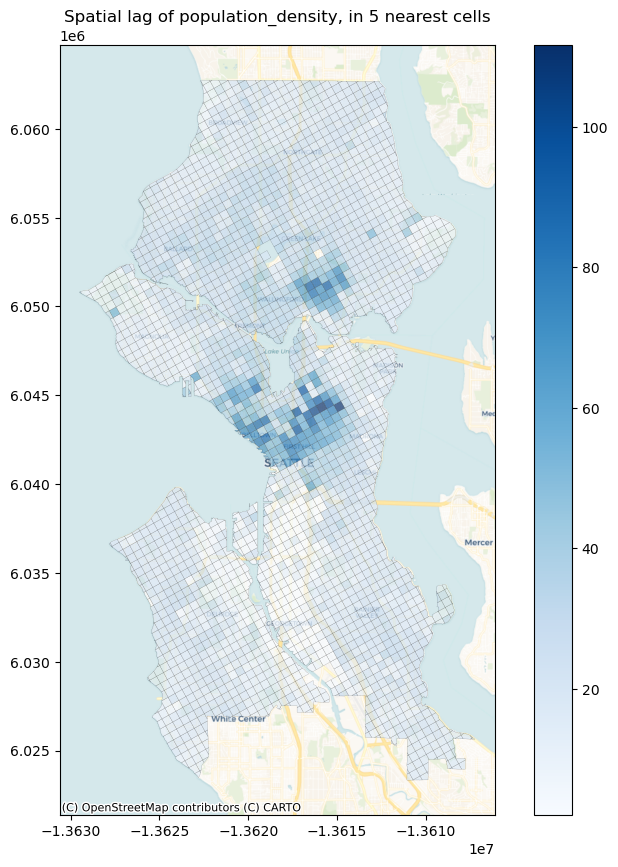

In [23]:
### Spatial lag 计算

def spatial_lag(weights, values):
    return weights.sparse.dot(values)
# 此函数用于计算空间滞后值。
# weights 是一个空间权重矩阵对象，通常来自 libpysal 库，代表了空间中各个单元之间的邻接关系。
# values 是一个包含每个空间单元某种属性值的数组。
# weights.sparse.dot(values) 执行的是稀疏矩阵乘法，将空间权重矩阵与属性值数组相乘，得到每个单元的空间滞后值。
# 这意味着每个单元的空间滞后值是其相邻单元属性值的加权和，权重由空间权重矩阵决定。

### 计算grid中心点最近的5个点

from sklearn.neighbors import NearestNeighbors
# NearestNeighbors 是 sklearn 库中的一个类，用于计算最近邻点

nbrs_grid = NearestNeighbors(n_neighbors=5).fit(grid_centroids)
# n_neighbors=5 表示要寻找每个点的最近 5 个邻居。
# fit(grid_centroids) 方法将 NearestNeighbors 对象拟合到 grid_centroids 数据上，grid_centroids每一行代表一个网格中心点的坐标。

distances_grid, indices_grid = nbrs_grid.kneighbors(grid_centroids)
# kneighbors(grid_centroids) 方法计算每个点到其最近 5 个邻居的距离和邻居的索引。
# distances_grid 是一个二维数组，每一行包含当前点到其 5 个最近邻居的距离；
# 这是一个二维数组（矩阵），包含每个点到其最近邻点的距离。具体来说，distances_grid[i, j] 表示第 i 个中心点到第 j 个最近邻点的距离。
# 如果你请求 n_neighbors=5，那么每个点将有 5 个最近邻距离，因此 distances_grid 的形状是 (n_samples, 5)，其中 n_samples 是你输入的中心点的数量
# indices_grid 也是一个二维数组，每一行包含当前点的 5 个最近邻居的索引。
# 这也是一个二维数组，包含每个点的最近邻点的索引（在原始数据集中）。具体来说，indices_grid[i, j] 表示第 i 个中心点的第 j 个最近邻点在原始 grid_centroids 中的索引。
# 这些索引可以用于从 grid_centroids 中提取实际的最近邻点位置或其他相关信息。

### 创造knn权重

from libpysal.weights import KNN
# KNN 是 libpysal 库中用于创建 K 近邻空间权重矩阵的类。

knn_weights_grid = KNN.from_array(indices_grid)
# from_array(indices_grid) 方法根据 indices_grid 创建一个 K 近邻空间权重矩阵 knn_weights_grid。
# 这个矩阵描述了每个网格中心点与其最近 5 个邻居之间的邻接关系。

pop_density_values = grid_gdf['pop_density'].values

grid_lag_knn5_popdensity = spatial_lag(knn_weights_grid, pop_density_values)
grid_gdf['lag_knn5_popdensity'] = grid_lag_knn5_popdensity

# 绘制
fig, ax = plt.subplots(figsize=(10, 10))
grid_gdf.plot(
    ax=ax, 
    column='lag_knn5_popdensity', 
    cmap='Blues',
    edgecolor='black',  
    linewidth=0.1, 
    alpha=0.7,
    legend=True  
)
plt.title("Spatial lag of population_density, in 5 nearest cells")
cx.add_basemap(ax, crs=grid_gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager,zoom=12)
plt.show()

#### 公园的选择尝试

In [24]:
parks = gpd.read_file('SeattleParkPoints.geojson')
parks_proj = parks.to_crs(epsg = 3857) # 计算几何中心 | 裁剪 | 面积计算 | 距离测量 | EPSG:3857 

# 将公园数据分配给格栅单元格,空间连接
park_joined_gdf = gpd.sjoin(parks_proj,grid_gdf,how = 'left',predicate = 'intersects')

# 计算每个格栅的单元格数量,分类聚合
# 在使用 geopandas 进行空间连接（sjoin）时，index_right 是 geopandas.sjoin 函数默认生成的列之一，用于表示与连接结果中的目标 GeoDataFrame 的索引相关联的行。
park_counts = park_joined_gdf.groupby('index_right').size()

# 将park_counts连接回原始grid_gdf,并且将没有公园的格栅赋值为0,空间映射
grid_gdf['park_counts'] = grid_gdf.index.map(park_counts).fillna(0).astype(int)
# grid_gdf.index.map(park_counts) 是将 grid_gdf 的索引映射到 park_counts 上，即根据 grid_gdf 的索引值从 park_counts 中查找对应的数量。
# 如果 grid_gdf 的索引值在 park_counts 中存在，则返回对应的数量；如果不存在，则返回 NaN

grid_gdf.head(3)

geometry  \
2852  POLYGON ((-13608159.542 6024257.989, -13607787...   
2853  POLYGON ((-13607787.488 6024509.448, -13607787...   
2945  POLYGON ((-13607809.247 6024549.043, -13607787...   

                               centroid  pop_density  lag_knn5_popdensity  \
2852  POINT (-13607929.576 6024182.438)     8.128217            18.379319   
2853  POINT (-13608073.372 6024456.949)     8.128217            15.194992   
2945   POINT (-13607794.62 6024535.642)     7.066775            16.256434   

      park_counts  
2852            0  
2853            0  
2945            0

/opt/anaconda3/lib/python3.13/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 74 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


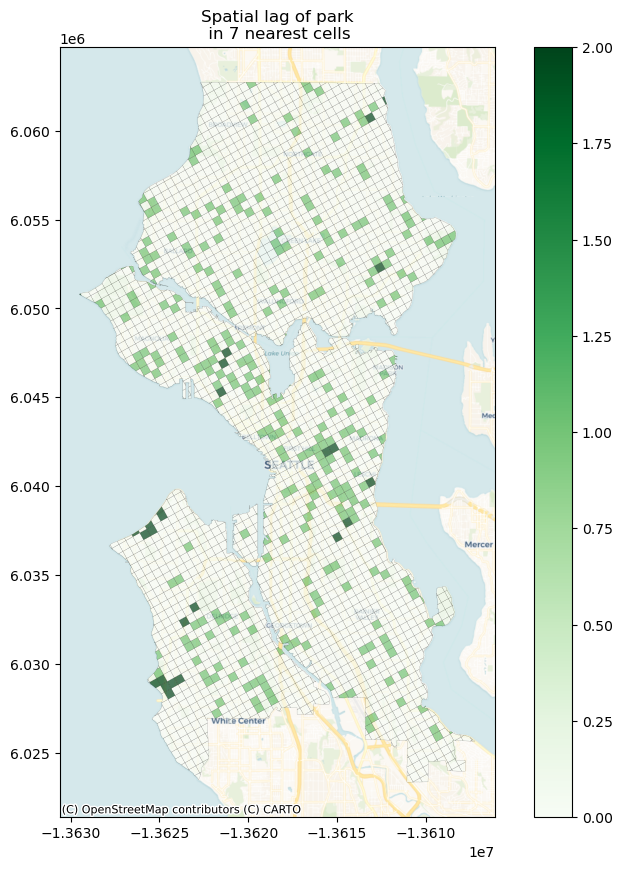

In [27]:
def spatial_lag(weights,values):
    return weights.sparse.dot(values)

nbrs_grid = NearestNeighbors(n_neighbors = 7).fit(grid_centroids)
distance_grid,indices_grid = nbrs_grid.kneighbors(grid_centroids)

knn_weights_grid = KNN.from_array(indices_grid)

park_counts = grid_gdf['park_counts']

grid_lag_knn7_park = spatial_lag(knn_weights_grid,park_counts)

grid_gdf['grid_lag_knn7_park'] = grid_lag_knn7_park

# 绘制
fig, ax = plt.subplots(figsize=(10, 10))
grid_gdf.plot(
    ax=ax, 
    column='grid_lag_knn7_park', 
    cmap='Greens',
    edgecolor='black',  
    linewidth=0.1, 
    alpha=0.7,
    legend=True  
)
plt.title("Spatial lag of park\n in 7 nearest cells")
cx.add_basemap(ax, crs=grid_gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager,zoom=12)
plt.show()

In [29]:
# 问题:点坐标的转换是适应哪些底图?shapely point 和坐标点之间的区别?